[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/susannaruecker/NLP-workshop/blob/main/01_BOW_sklearn_FFN.ipynb)

In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import Ridge
import os
import requests

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Data and Task Description

* in all notebooks we'll use the public datast *10kGNAD* (10k German News Articles Dataset), for more info see https://tblock.github.io/10kGNAD/
* 10k **German News Articles** classified into **9 labels** (Topics/Rubrics)
    * Panorama, Web, International, Wirtschaft, Sport, Inland, Etat, Wissenschaft, Kultur 
* already split into train and test set
    * keep in mind, normally we want to have 3 splits (called train, dev/val, test), here we will use the so called test split more like you would use a development/validation split)
* so - not very surprising - we will do the task of supervised **text classification**
* note: this is a very simple NLP task, you absolutely don't need DL/BERT to solve it well, but for learning purposes it's good
* the _real_ benefit of DL-Models and BERT and friends is much more apparent in complex tasks, such as question answering, translation, sequence labelling, relation extraction, text generation, chatbots, summarization, ...


### Download data and create Dataframes

In [2]:
os.makedirs('10kGNAD', exist_ok=True) # create folder in Colab

In [3]:
# download public 10kGNAD train and test data from github repo

url_train = 'https://raw.githubusercontent.com/tblock/10kGNAD/master/train.csv'
read_train = requests.get(url_train, allow_redirects=True)
open('10kGNAD/train.csv', 'wb').write(read_train.content)

url_test = 'https://raw.githubusercontent.com/tblock/10kGNAD/master/test.csv'
read_test = requests.get(url_test, allow_redirects=True)
open('10kGNAD/test.csv', 'wb').write(read_test.content)

2755020

In [4]:
!head -n 2 10kGNAD/train.csv

Sport;21-Jähriger fällt wohl bis Saisonende aus. Wien – Rapid muss wohl bis Saisonende auf Offensivspieler Thomas Murg verzichten. Der im Winter aus Ried gekommene 21-Jährige erlitt beim 0:4-Heimdebakel gegen Admira Wacker Mödling am Samstag einen Teilriss des Innenbandes im linken Knie, wie eine Magnetresonanz-Untersuchung am Donnerstag ergab. Murg erhielt eine Schiene, muss aber nicht operiert werden. Dennoch steht ihm eine mehrwöchige Pause bevor.
Kultur;'Erfundene Bilder zu Filmen, die als verloren gelten: "The Forbidden Room" von Guy Maddin und Evan Johnson ist ein surrealer Ritt durch die magischen Labyrinthe des frühen Kinos. Wien – Die Filmgeschichte ist ein Friedhof der Verlorenen. Unter den Begrabenen finden sich zahllose Filme, von denen nur noch mysteriös oder abenteuerlich klingende Namen kursieren; und solche, über die verstreut herumliegendes Sekundärmaterial Aufschluss erlaubt. Einer davon ist The Forbidden Room, ein Two-Reeler von 1913/14, den der arbeitswütige US-Regi

In [5]:
df_train = pd.read_csv("10kGNAD/train.csv", sep = ';', 
                       encoding = "utf-8", 
                       quotechar='\'', header=None, names = ["label", "article"])

df_test = pd.read_csv("10kGNAD/test.csv", sep = ';', 
                      encoding = "utf-8", 
                      quotechar='\'', header=None, names = ["label", "article"])

In [6]:
df_train.head()

,label,article
0,Sport,21-Jähriger fällt wohl bis Saisonende aus. Wie...
1,Kultur,"Erfundene Bilder zu Filmen, die als verloren g..."
2,Web,Der frischgekürte CEO Sundar Pichai setzt auf ...
3,Wirtschaft,"Putin: ""Einigung, dass wir Menge auf Niveau vo..."
4,Inland,Estland sieht den künftigen österreichischen P...


In [7]:
print(df_train.shape, df_test.shape)

(9245, 2) (1028, 2)


In [8]:
df_train.label.value_counts()

Panorama         1510
Web              1509
International    1360
Wirtschaft       1270
Sport            1081
Inland            913
Etat              601
Wissenschaft      516
Kultur            485
Name: label, dtype: int64

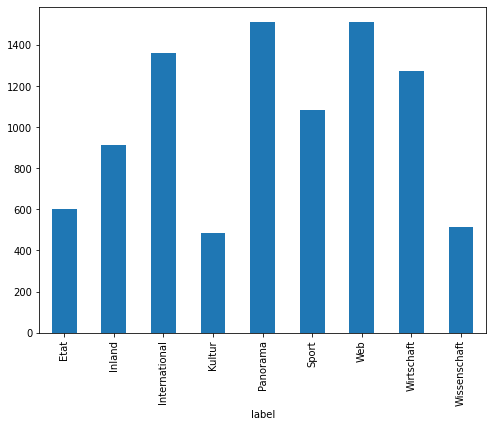

In [9]:
fig = plt.figure(figsize=(8,6))
df_train.groupby('label').article.count().plot.bar(ylim=0)
plt.show()

### Transform labels to integers, make sure to keep mapping for later

In [10]:
# use the LabelEncoder vom scklearn, and save the order/mapping for later
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
label_encoded=le.fit(df_train.label)
print(le.classes_)

label_to_id = {c: i for (i, c) in enumerate(le.classes_)}
print(label_to_id)

id_to_label = {v: k for k, v in label_to_id.items()}
print(id_to_label)

['Etat' 'Inland' 'International' 'Kultur' 'Panorama' 'Sport' 'Web'
 'Wirtschaft' 'Wissenschaft']
{'Etat': 0, 'Inland': 1, 'International': 2, 'Kultur': 3, 'Panorama': 4, 'Sport': 5, 'Web': 6, 'Wirtschaft': 7, 'Wissenschaft': 8}
{0: 'Etat', 1: 'Inland', 2: 'International', 3: 'Kultur', 4: 'Panorama', 5: 'Sport', 6: 'Web', 7: 'Wirtschaft', 8: 'Wissenschaft'}


In [11]:
# add columns with label_id
df_train["label_id"] = le.transform(df_train.label)
df_test["label_id"] = le.transform(df_test.label)

In [12]:
# get label_names (in same order, used for classification reports)
label_names = list(le.classes_)
label_names

['Etat',
 'Inland',
 'International',
 'Kultur',
 'Panorama',
 'Sport',
 'Web',
 'Wirtschaft',
 'Wissenschaft']

In [13]:
# see if everything looks good
df_train.head(10)

,label,article,label_id
0,Sport,21-Jähriger fällt wohl bis Saisonende aus. Wie...,5
1,Kultur,"Erfundene Bilder zu Filmen, die als verloren g...",3
2,Web,Der frischgekürte CEO Sundar Pichai setzt auf ...,6
3,Wirtschaft,"Putin: ""Einigung, dass wir Menge auf Niveau vo...",7
4,Inland,Estland sieht den künftigen österreichischen P...,1
5,Wirtschaft,Der Welser Stempelhersteller verbreitert sich ...,7
6,Sport,Traditionsklub setzt sich gegen den FC Utrecht...,5
7,Etat,Finanzausschuss tagte Montag: Konfliktthemen S...,0
8,International,Militär setzt Offensive an Grenze zu Afghanist...,2
9,Sport,Abschiedstournee für Guardiola beginnt beim HS...,5


In [14]:
df_train[df_train.label == "Panorama"].head()

,label,article,label_id
15,Panorama,Polizei ermittelt wegen Vandalismus. Moskau – ...,4
30,Panorama,Die Regierung in Wien ist sich einig: Bilder v...,4
39,Panorama,Zahl der Fluchtversuche am Eurotunnel zurückge...,4
40,Panorama,Verletzungen deuten laut Polizei auf Absturz h...,4
54,Panorama,Die Aufhebung der verpflichtenden Untersuchung...,4


In [15]:
# get an idea of article length in tokens (in df_train)

tokenizer = nltk.tokenize.word_tokenize #  a basic tokenizer from the nltk library, so we can count tokens
print(tokenizer("Das ist ein Beispiel."))

lens = []
for t in df_train.article:
  lens.append(len(tokenizer(t)))

['Das', 'ist', 'ein', 'Beispiel', '.']


Mean article length: 413.9


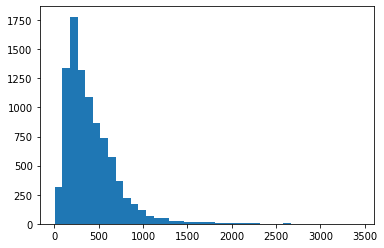

In [16]:
print("Mean article length:", np.mean(lens).round(2))
plt.hist(lens, 40);

## BOW-Features

* Bag-of-Words: representing text with their token/n-gram counts
* n-grams: groups of tokens ("Vereinigte Staaten", "mehr oder weniger")
* no knowlegde of sequence/order of text, the relationship between tokens or their _meaning_
* still works well in some simple tasks
* most of the work is done by the CountVecotrizer from sklearn
* you should think abput preprocessing steps

In [17]:
# if we want to delete stopwords, you can load predefined list (or create your own)

from nltk.corpus import stopwords
nltk.download('stopwords')
german_stopwords = stopwords.words('german')

MAX_FEATURES = 2000 # choose a max number of features to use (most frequent ones remain)

vectorizer = CountVectorizer(analyzer='word',
                             ngram_range= (1, 2),
                             max_features = MAX_FEATURES,
                             
                             # when you want to delete stopwords do:
                             stop_words = german_stopwords # depends on your task (and think about what happens in combination with other preprocessing steps e.g. lemmatization!)
                             
                             # we use default tokenizer and preprocessor (just lowercasing)
                             # we COULD also give a specific tokenizer and/or preprocessor (lemmatization!) to use
                             # see last part if this Notebook for some spacy NLP preprocessing possibilities
                             # an more possibilities (e.g. min/max document frequency)
                             
                             )

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [18]:
vectorizer.fit_transform(["Das ist ein Beispiel mit Entfernung von Stopwörtern."])
print(vectorizer.vocabulary_)

{'beispiel': 0, 'entfernung': 2, 'stopwörtern': 4, 'beispiel entfernung': 1, 'entfernung stopwörtern': 3}


In [19]:
# train vectorizer on train texts and transform both train and test

X_train = vectorizer.fit_transform(df_train.article).toarray()           # only fit on train!
X_test = vectorizer.transform(df_test.article).toarray()                 # keep in mind: if you want to transform NEW text (e.g. in inference) at a later point you would need to save the vectorizer (config and/or vocab)

In [20]:
print(X_train.shape, X_test.shape)

(9245, 2000) (1028, 2000)


In [21]:
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 1, 0]])

In [22]:
#vectorizer.vocabulary_ # vocabulary of tokenizer: dict mapping tokens (n-grams) to their ids

In [23]:
# labels (also known as target, gold)
y_train = df_train.label_id.values
y_test = df_test.label_id.values
print(y_train.shape, y_test.shape)

(9245,) (1028,)


### First: Try some simple models from scikit-learn

(Just for having baselines/comparison, of course this could/should be done more carefully...)

In [24]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import classification_report

In [25]:
# try out some of your favourite classifiers
model_dict = {
              'MultinomialNB': MultinomialNB(),
              'RandomForest': RandomForestClassifier(),
              'LogisticRegression': LogisticRegression(max_iter = 500),
              
              #'LinearSVC': LinearSVC(max_iter = 500),
              #'KNN': KNeighborsClassifier(10),
              #'DecisionTree': DecisionTreeClassifier(),
              }

for name, model in model_dict.items():
    print(name)
    model = model
    
    model.fit(X_train, y_train)

    # accuracy on test set
    accuracy = model.score(X_test, y_test)
    print("Accuracy:", accuracy)

    pred_test = model.predict(X_test)
    print(classification_report(y_test, pred_test, target_names=label_names))
    print("\n-------------------------------------------")

MultinomialNB
Accuracy: 0.7986381322957199
               precision    recall  f1-score   support

         Etat       0.77      0.61      0.68        67
       Inland       0.75      0.80      0.78       102
International       0.83      0.78      0.80       151
       Kultur       0.71      0.91      0.80        54
     Panorama       0.77      0.74      0.76       168
        Sport       0.98      0.94      0.96       120
          Web       0.90      0.79      0.84       168
   Wirtschaft       0.66      0.77      0.71       141
 Wissenschaft       0.78      0.91      0.84        57

     accuracy                           0.80      1028
    macro avg       0.80      0.81      0.80      1028
 weighted avg       0.81      0.80      0.80      1028


-------------------------------------------
RandomForest
Accuracy: 0.7577821011673151
               precision    recall  f1-score   support

         Etat       0.86      0.45      0.59        67
       Inland       0.72      0.75      0

### Now: FFN classifier, still with BOW features

* we'll keep Keras for now, for BERT (other notebook) we switch to PyTorch
* input: BOW-vector
* output: logits/probabilities for the 9 classes/labels
* hidden layer(s), maybe try Dropout

In [26]:
# make labels into matrix --> only necessary if we want to use categorical_crossentropy, not when using sparse_categorical_crossentropy
from tensorflow.keras.utils import to_categorical
y_train_matrix = to_categorical(y_train, dtype ="int")
y_test_matrix = to_categorical(y_test, dtype ="int")

In [27]:
y_train_matrix[:2] # "Sport" or 5, "Kultur" or 3

array([[0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0]])

In [28]:
y_train[:2]

array([5, 3])

In [29]:
# just an overview
print(X_train.shape, y_train.shape, y_train_matrix.shape)
print(X_test.shape, y_test.shape, y_test_matrix.shape)

(9245, 2000) (9245,) (9245, 9)
(1028, 2000) (1028,) (1028, 9)


In [30]:
from tensorflow.keras import models, layers, optimizers, losses

ffn = models.Sequential()
ffn.add(layers.InputLayer(input_shape=(MAX_FEATURES,))) # BOW has shape MAX_FEATURES
ffn.add(layers.Dropout(.2))
ffn.add(layers.Dense(64, activation="sigmoid"))
ffn.add(layers.Dense(9, activation="softmax")) # nr of labels

In [31]:
ffn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 2000)              0         
                                                                 
 dense (Dense)               (None, 64)                128064    
                                                                 
 dense_1 (Dense)             (None, 9)                 585       
                                                                 
Total params: 128,649
Trainable params: 128,649
Non-trainable params: 0
_________________________________________________________________


In [33]:
ffn.compile(optimizers.Adam(learning_rate=0.0005),
            #optimizer = optimizers.SGD(learning_rate=0.01),
            #loss='categorical_crossentropy',                         # with this you would need to use y_train_matrix and y_test_matrix
            loss='sparse_categorical_crossentropy',                   # can use y_train and y_test
            metrics=['accuracy']
            )

In [34]:
# when using sparse_categorical_crossentropy:
history = ffn.fit(X_train, y_train, epochs=15, batch_size=32, verbose=1,
                  validation_data=(X_test, y_test)
                  )

# when using categorical_crossentropy:
#history = ffn.fit(X_train, y_train_matrix, epochs=15, batch_size=32, verbose=1,
#                  validation_data=(X_test, y_test_matrix)
#                  )

Epoch 1/15
289/289 [==============================] - 3s 5ms/step - loss: 1.5595 - accuracy: 0.5688 - val_loss: 1.1572 - val_accuracy: 0.7072
Epoch 2/15
289/289 [==============================] - 1s 4ms/step - loss: 0.9984 - accuracy: 0.7509 - val_loss: 0.8656 - val_accuracy: 0.7840
Epoch 3/15
289/289 [==============================] - 1s 4ms/step - loss: 0.7729 - accuracy: 0.8025 - val_loss: 0.7229 - val_accuracy: 0.8093
Epoch 4/15
289/289 [==============================] - 1s 4ms/step - loss: 0.6407 - accuracy: 0.8296 - val_loss: 0.6477 - val_accuracy: 0.8268
Epoch 5/15
289/289 [==============================] - 1s 4ms/step - loss: 0.5575 - accuracy: 0.8447 - val_loss: 0.6015 - val_accuracy: 0.8346
Epoch 6/15
289/289 [==============================] - 1s 5ms/step - loss: 0.4964 - accuracy: 0.8609 - val_loss: 0.5719 - val_accuracy: 0.8356
Epoch 7/15
289/289 [==============================] - 1s 4ms/step - loss: 0.4489 - accuracy: 0.8743 - val_loss: 0.5538 - val_accuracy: 0.8317
Epoch 

In [35]:
loss, acc = ffn.evaluate(X_test, y_test)
#loss, acc = ffn.evaluate(X_test, y_test_matrix)

print(f"\nloss: {loss} \n acc: {acc}")

33/33 [==============================] - 0s 3ms/step - loss: 0.5464 - accuracy: 0.8249

loss: 0.546394407749176 
 acc: 0.8249027132987976


### Look at the output and how to get our labels from it

In [37]:
pred_test_prob = ffn.predict(X_test)
print(pred_test_prob[0])                      # logits/probabilities for each class
pred_test = np.argmax(pred_test_prob,axis=1)  # get the most pobable prediction from the logits
print(pred_test[0])
print("\n----")
print(classification_report(y_test, pred_test, target_names=label_names))

[1.2255017e-02 5.6238407e-01 4.4061232e-04 3.2676365e-03 3.4022352e-03
 3.0469329e-03 3.1869560e-02 9.4161943e-02 2.8917196e-01]
1

----
               precision    recall  f1-score   support

         Etat       0.78      0.67      0.72        67
       Inland       0.79      0.78      0.79       102
International       0.87      0.81      0.84       151
       Kultur       0.75      0.78      0.76        54
     Panorama       0.72      0.83      0.77       168
        Sport       0.98      0.96      0.97       120
          Web       0.88      0.86      0.87       168
   Wirtschaft       0.78      0.78      0.78       141
 Wissenschaft       0.91      0.86      0.88        57

     accuracy                           0.82      1028
    macro avg       0.83      0.82      0.82      1028
 weighted avg       0.83      0.82      0.83      1028



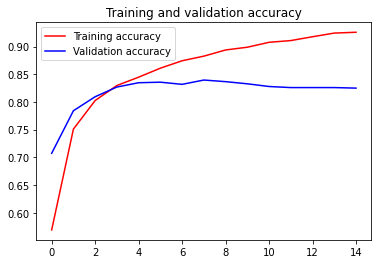

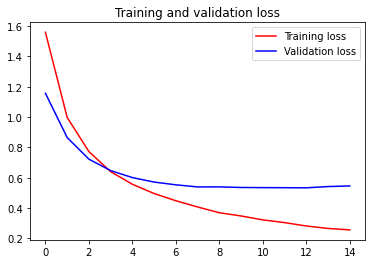

<Figure size 432x288 with 0 Axes>

In [38]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

## Now to the fun part: Predicting new text

* feel free to be creative and add your own masterpiece of an article
* we will use these for all models
* keep in mind: we always need the same preprocessing/feature extraction steps as in training
    * here: BOW (with the _same_ and already trained CountVectorizer)

In [39]:
new_texts = [
             """Der Südbadische Fußballverband (SBFV) hat auf die aktuelle Entwicklung in der Corona-Pandemie reagiert. Der Verbandsvorstand beschloss am Abend, mit dem Spielbetrieb in allen 
             südbadischen Alters- und Spielklassen von der Verbandsliga abwärts vorzeitig in die Winterpause zu gehen.""",
             
             """Vor dem Bund-Länder-Gespräch über weitere Einschränkungen und Verbote werden die Forderungen nach einem harten Lockdown lauter. Der Präsident des Städtetages Baden-Württemberg, 
             Mannheims Oberbürgermeister Peter Kurz (SPD), hält ihn für nötig, wenn sich die Corona-Lage in den kommenden Tagen weiter verschärft.
             """,
             
             """Dank einer taktischen Umstellung für die letzten fünf Spielminuten und dem viel zitierten Spielglück haben die Basketballerinnen des USC Freiburg ihren Heimnimbus in dieser Saison gewahrt und sich in der 
             Spitzengruppe der Bundesliga festgekrallt. Am Samstagabend gewannen die Eisvögel im sechsten Spiel in der Unihalle zum sechsten Mal
             """,
             
             """Abgesehen von pandemiegeschuldeter Einlasskontrolle und Maskenpflicht war es wie früher: das Freiburger Konzerthaus – ausverkauft! Kein Wunder, wenn die aus Südbaden stammende Weltklasse-Geigerin 
             Anne-Sophie Mutter und ihre seit nunmehr zehn Jahren bestehenden Mutter’s Virtuosi auftreten. Mittelpunkt und Rahmen jetzt: Antonio Vivaldi.
             """,
             
             """Ja, es ist ein Jugendstück. Anton Tschechow war 18 Jahre alt, als er es schrieb - und wieder vernichtete, nachdem es kein Gehör gefunden hatte. 
             Die Erstschrift hat sich erhalten und wurde 1920 unter dem – nicht von Tschechow stammenden – Titel "Platonow" veröffentlicht. Eine Jugendsünde ist es nicht, 
             denn viele Motive aus dem späteren Werk klingen an. Nur: Wenn man es vom Blatt spielte, dauerte die Aufführung geschlagene sechs Stunden, länger als jede Wagner-Oper. 
             """,

             #
             # add your own!
             #
             
]


In [40]:
X_vectorized = vectorizer.transform(new_texts).toarray()
X_vectorized.shape

(5, 2000)

In [41]:
probs = ffn.predict(X_vectorized)
print(probs) # what the model outputs
print("----")

labels = np.argmax(probs,axis=1) # get real labels from it
print(labels)
print("----")

print( [ (l, id_to_label[l]) for l in labels]) # get label names from label_id

# seems okay, but not perfect ("Web" for the first one is kind of far fetched...?)

[[0.07388432 0.0446753  0.08067768 0.10583924 0.11652372 0.07340086
  0.4000082  0.05512676 0.04986391]
 [0.04019894 0.02831148 0.3554159  0.05284432 0.24926615 0.05674861
  0.0630035  0.1434928  0.01071822]
 [0.03518673 0.02057872 0.03444702 0.07514039 0.04345593 0.5864436
  0.15767121 0.02861441 0.01846208]
 [0.16041969 0.05439338 0.09957292 0.11877248 0.23234296 0.06815417
  0.05752698 0.15559842 0.05321898]
 [0.04024337 0.05784413 0.01921618 0.64817864 0.06456467 0.05771732
  0.05031291 0.02251688 0.03940596]]
----
[6 2 5 4 3]
----
[(6, 'Web'), (2, 'International'), (5, 'Sport'), (4, 'Panorama'), (3, 'Kultur')]


#### Out of curiosity: Predicting new texts with Logistic Regression

(Model should still be in memory known as `model`)

In [42]:
LR_labels = model.predict(X_vectorized)
print(LR_labels)

print( [ (l, id_to_label[l]) for l in LR_labels]) # get label names from label_id


[6 2 5 7 3]
[(6, 'Web'), (2, 'International'), (5, 'Sport'), (7, 'Wirtschaft'), (3, 'Kultur')]


----

## Appendix: Lemmatization (and more) with Spacy

Spacy models can do a lot of NLP magic for you, such as lemmatization, POS- or NER-tagging. It is very slow though when processing lots of text. (And the German models are not that goog, as you can easily see in the examples below.)

In [ ]:
!pip install --upgrade spacy
!python -m spacy download de_core_news_sm

  Using cached https://github.com/explosion/spacy-models/releases/download/de_core_news_sm-3.2.0/de_core_news_sm-3.2.0-py3-none-any.whl (19.1 MB)
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [ ]:
import spacy
nlp = spacy.load('de_core_news_sm')

samples = ['Das hier sind verschiedene Beispiele, die Lemmatisierung und mehr zeigen sollen.', 
           'Wenn Fliegen hinter Fliegen fliegen, fliegen Fliegen Fliegen nach.',
           'Ich mag Daten, du magst Daten, wir mögen alle Daten, Herr Bert mag NLP und INWT Statistics mag alles.',
           ]

for sample in samples:
  print("-------")
  sample_nlped = nlp(sample)
  
  for token in sample_nlped:
    print(token.text, "\t", token.lemma_, "\t", token.pos_, "\t", token.ent_type_)

-------
Das 	 der 	 DET 	 
hier 	 hier 	 ADV 	 
sind 	 sein 	 AUX 	 
verschiedene 	 verschieden 	 ADJ 	 
Beispiele 	 Beispiel 	 NOUN 	 
, 	 , 	 PUNCT 	 
die 	 der 	 DET 	 
Lemmatisierung 	 Lemmatisierung 	 NOUN 	 
und 	 und 	 CCONJ 	 
mehr 	 mehr 	 PRON 	 
zeigen 	 zeigen 	 VERB 	 
sollen 	 sollen 	 AUX 	 
. 	 . 	 PUNCT 	 
-------
Wenn 	 Wenn 	 SCONJ 	 
Fliegen 	 Fliege 	 NOUN 	 
hinter 	 hinter 	 ADP 	 
Fliegen 	 Fliege 	 NOUN 	 
fliegen 	 fliegen 	 VERB 	 
, 	 , 	 PUNCT 	 
fliegen 	 fliegen 	 VERB 	 
Fliegen 	 Fliege 	 NOUN 	 
Fliegen 	 Fliege 	 NOUN 	 
nach 	 nach 	 ADP 	 
. 	 . 	 PUNCT 	 
-------
Ich 	 Ich 	 PRON 	 
mag 	 mögen 	 AUX 	 
Daten 	 Datum 	 NOUN 	 
, 	 , 	 PUNCT 	 
du 	 du 	 PRON 	 
magst 	 mögen 	 VERB 	 
Daten 	 Datum 	 NOUN 	 
, 	 , 	 PUNCT 	 
wir 	 ich 	 PRON 	 
mögen 	 mögen 	 AUX 	 
alle 	 all 	 DET 	 
Daten 	 Datum 	 NOUN 	 
, 	 , 	 PUNCT 	 
Herr 	 Herr 	 NOUN 	 
Bert 	 Bert 	 PROPN 	 
mag 	 mögen 	 AUX 	 
NLP 	 NLP 	 PROPN 	 
und 	 und 	 CCONJ 	 
INWT 	 INWT 	 P

### Another very cool NLP-library is [flairNLP](https://github.com/flairNLP/flair)

* PoS-tagging, NER, different embeddings, ...
* Try it out! :)